In [1]:
import pandas as pd
import numpy as np
import copy
%matplotlib inline


In [2]:
df_flights = pd.read_csv('https://raw.githubusercontent.com/ismayc/pnwflights14/master/data/flights.csv')

df_flights.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
0,2014,1,1,1.0,96.0,235.0,70.0,AS,N508AS,145,PDX,ANC,194.0,1542,0.0,1.0
1,2014,1,1,4.0,-6.0,738.0,-23.0,US,N195UW,1830,SEA,CLT,252.0,2279,0.0,4.0
2,2014,1,1,8.0,13.0,548.0,-4.0,UA,N37422,1609,PDX,IAH,201.0,1825,0.0,8.0
3,2014,1,1,28.0,-2.0,800.0,-23.0,US,N547UW,466,PDX,CLT,251.0,2282,0.0,28.0
4,2014,1,1,34.0,44.0,325.0,43.0,AS,N762AS,121,SEA,ANC,201.0,1448,0.0,34.0


In [3]:
print(df_flights.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162049 entries, 0 to 162048
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   year       162049 non-null  int64  
 1   month      162049 non-null  int64  
 2   day        162049 non-null  int64  
 3   dep_time   161192 non-null  float64
 4   dep_delay  161192 non-null  float64
 5   arr_time   161061 non-null  float64
 6   arr_delay  160748 non-null  float64
 7   carrier    162049 non-null  object 
 8   tailnum    161801 non-null  object 
 9   flight     162049 non-null  int64  
 10  origin     162049 non-null  object 
 11  dest       162049 non-null  object 
 12  air_time   160748 non-null  float64
 13  distance   162049 non-null  int64  
 14  hour       161192 non-null  float64
 15  minute     161192 non-null  float64
dtypes: float64(7), int64(5), object(4)
memory usage: 19.8+ MB
None


<AxesSubplot:title={'center':'dep_time'}, xlabel='origin'>

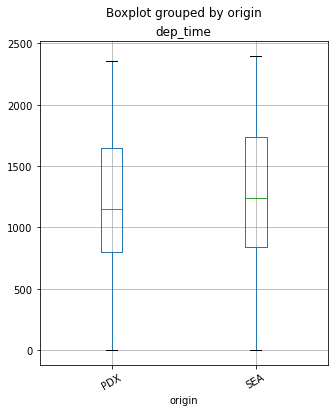

In [4]:
df_flights.boxplot('dep_time','origin',rot = 30,figsize=(5,6))

As you will only be dealing with categorical features in this tutorial, it's better to filter them out. You can create a separate DataFrame consisting of only these features by running the following command. The method .copy() is used here so that any changes made in new DataFrame don't get reflected in the original one.

In [5]:
cat_df_flights = df_flights.select_dtypes(include=['object']).copy()
cat_df_flights.head()


,carrier,tailnum,origin,dest
0,AS,N508AS,PDX,ANC
1,US,N195UW,SEA,CLT
2,UA,N37422,PDX,IAH
3,US,N547UW,PDX,CLT
4,AS,N762AS,SEA,ANC


One of the most common data pre-processing steps is to check for null values in the dataset. You can get the total number of missing values in the DataFrame by the following one liner code:

In [6]:
print(cat_df_flights.isnull().values.sum())
print(cat_df_flights.isnull().sum())  # column wise distribution on nulls

248
carrier      0
tailnum    248
origin       0
dest         0
dtype: int64


It seems that only the tailnum column has null values. You can do a mode imputation for those null values. The function fillna() is handy for such operations.

Note the chaining of method .value_counts() in the code below. This returns the frequency distribution of each category in the feature, and then selecting the top category, which is the mode, with the .index attribute.

In [7]:
cat_df_flights = cat_df_flights.fillna(cat_df_flights['tailnum'].value_counts().index[0])

Another Exploratory Data Analysis (EDA) step that you might want to do on categorical features is the frequency distribution of categories within the feature, which can be done with the .value_counts() method as described earlier.

In [9]:
print(cat_df_flights['carrier'].value_counts())
print(cat_df_flights['carrier'].value_counts().count())  # number of categories

AS    62460
WN    23355
OO    18710
DL    16716
UA    16671
AA     7586
US     5946
B6     3540
VX     3272
F9     2698
HA     1095
Name: carrier, dtype: int64
11


plot the data

C:\Users\ddalton\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


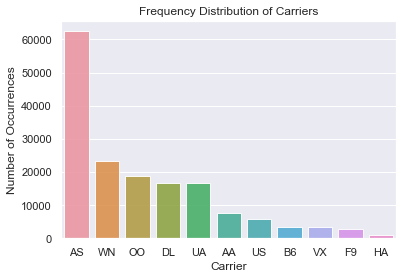

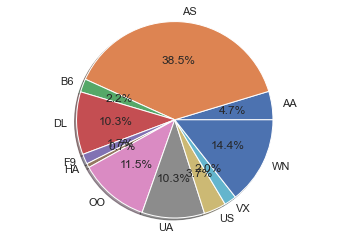

In [11]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
carrier_count = cat_df_flights['carrier'].value_counts()
sns.set(style="darkgrid")
sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
plt.title('Frequency Distribution of Carriers')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Carrier', fontsize=12)
plt.show()

# pie chart
labels = cat_df_flights['carrier'].astype('category').cat.categories.tolist()
counts = cat_df_flights['carrier'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

Encoding Categorical Data
You will now learn different techniques to encode the categorical features to numeric quantities. To keep it simple, you will apply these encoding methods only on the carrier column. However, the same approach can be extended to all columns.

The techniques that you'll cover are the following:

Replacing values
Encoding labels
One-Hot encoding
Binary encoding
Backward difference encoding
Miscellaneous features
Replace Values
Let's start with the most basic method, which is just replacing the categories with the desired numbers. This can be achieved with the help of the replace() function in pandas. The idea is that you have the liberty to choose whatever numbers you want to assign to the categories according to the business use case.

You will now create a dictionary which contains mapping numbers for each category in the carrier column:

In [12]:
replace_map = {'carrier': {'AA': 1, 'AS': 2, 'B6': 3, 'DL': 4,
                                  'F9': 5, 'HA': 6, 'OO': 7 , 'UA': 8 , 'US': 9,'VX': 10,'WN': 11}}

Note that defining a mapping via a hard coded dictionary is easy when the number of categories is low, like in this case which is 11. You can achieve the same mapping with the help of dictionary comprehensions as shown below. This will be useful when the categories count is high and you don't want to type out each mapping. You will store the category names in a list called labels and then zip it to a seqeunce of numbers and iterate over it.

In [13]:
labels = cat_df_flights['carrier'].astype('category').cat.categories.tolist()
replace_map_comp = {'carrier' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

print(replace_map_comp)

{'carrier': {'AA': 1, 'AS': 2, 'B6': 3, 'DL': 4, 'F9': 5, 'HA': 6, 'OO': 7, 'UA': 8, 'US': 9, 'VX': 10, 'WN': 11}}


Throughout this tutorial, you will be making a copy of the dataset via the .copy() method to practice each encoding technique to ensure that the original DataFrame stays intact and whatever changes you are doing happen only in the copied one.

In [14]:
cat_df_flights_replace = cat_df_flights.copy()
cat_df_flights_replace.replace(replace_map_comp, inplace=True)

print(cat_df_flights_replace.head())

   carrier tailnum origin dest
0        2  N508AS    PDX  ANC
1        9  N195UW    SEA  CLT
2        8  N37422    PDX  IAH
3        9  N547UW    PDX  CLT
4        2  N762AS    SEA  ANC


Tip: in Python, it's a good practice to typecast categorical features to a category dtype because they make the operations on such columns much faster than the object dtype. You can do the typecasting by using .astype() method on your columns like shown below:

In [15]:
cat_df_flights_lc = cat_df_flights.copy()
cat_df_flights_lc['carrier'] = cat_df_flights_lc['carrier'].astype('category')
cat_df_flights_lc['origin'] = cat_df_flights_lc['origin'].astype('category')                                                              

print(cat_df_flights_lc.dtypes)

carrier    category
tailnum      object
origin     category
dest         object
dtype: object


Label Encoding
Another approach is to encode categorical values with a technique called "label encoding", which allows you to convert each value in a column to a number. Numerical labels are always between 0 and n_categories-1.

You can do label encoding via attributes .cat.codes on your DataFrame's column.

In [16]:
cat_df_flights_lc['carrier'] = cat_df_flights_lc['carrier'].cat.codes
cat_df_flights_lc.head() #alphabetically labeled from 0 to 10

,carrier,tailnum,origin,dest
0,1,N508AS,PDX,ANC
1,8,N195UW,SEA,CLT
2,7,N37422,PDX,IAH
3,8,N547UW,PDX,CLT
4,1,N762AS,SEA,ANC


Sometimes, you might just want to encode a bunch of categories within a feature to some numeric value and encode all the other categories to some other numeric value.

You could do this by using numpy's where() function like shown below. You will encode all the US carrier flights to value 1 and other carriers to value 0. This will create a new column in your DataFrame with the encodings. Later, if you want to drop the original column, you can do so by using the drop() function in pandas.

In [17]:
cat_df_flights_specific = cat_df_flights.copy()
cat_df_flights_specific['US_code'] = np.where(cat_df_flights_specific['carrier'].str.contains('US'), 1, 0)

cat_df_flights_specific.head()

,carrier,tailnum,origin,dest,US_code
0,AS,N508AS,PDX,ANC,0
1,US,N195UW,SEA,CLT,1
2,UA,N37422,PDX,IAH,0
3,US,N547UW,PDX,CLT,1
4,AS,N762AS,SEA,ANC,0


You can achieve the same label encoding using scikit-learn's LabelEncoder:

In [18]:
cat_df_flights_sklearn = cat_df_flights.copy()

from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
cat_df_flights_sklearn['carrier_code'] = lb_make.fit_transform(cat_df_flights['carrier'])

cat_df_flights_sklearn.head() #Results in appending a new column to df

,carrier,tailnum,origin,dest,carrier_code
0,AS,N508AS,PDX,ANC,1
1,US,N195UW,SEA,CLT,8
2,UA,N37422,PDX,IAH,7
3,US,N547UW,PDX,CLT,8
4,AS,N762AS,SEA,ANC,1


### One Hot encoding
The basic strategy is to convert each category value into a new column and assign a 1 or 0 (True/False) value to the column. This has the benefit of not weighting a value improperly.

There are many libraries out there that support one-hot encoding but the simplest one is using pandas' .get_dummies() method.

This function is named this way because it creates dummy/indicator variables (1 or 0). There are mainly three arguments important here, the first one is the DataFrame you want to encode on, second being the columns argument which lets you specify the columns you want to do encoding on, and third, the prefix argument which lets you specify the prefix for the new columns that will be created after encoding.

In [19]:
cat_df_flights_onehot = cat_df_flights.copy()
cat_df_flights_onehot = pd.get_dummies(cat_df_flights_onehot, columns=['carrier'], prefix = ['carrier'])

print(cat_df_flights_onehot.head())

  tailnum origin dest  carrier_AA  carrier_AS  carrier_B6  carrier_DL  \
0  N508AS    PDX  ANC           0           1           0           0   
1  N195UW    SEA  CLT           0           0           0           0   
2  N37422    PDX  IAH           0           0           0           0   
3  N547UW    PDX  CLT           0           0           0           0   
4  N762AS    SEA  ANC           0           1           0           0   

   carrier_F9  carrier_HA  carrier_OO  carrier_UA  carrier_US  carrier_VX  \
0           0           0           0           0           0           0   
1           0           0           0           0           1           0   
2           0           0           0           1           0           0   
3           0           0           0           0           1           0   
4           0           0           0           0           0           0   

   carrier_WN  
0           0  
1           0  
2           0  
3           0  
4           0  


As you can see, the column carrier_AS gets value 1 at the 0th and 4th observation points as those points had the AS category labeled in the original DataFrame. Likewise for other columns also.

scikit-learn also supports one hot encoding via LabelBinarizer and OneHotEncoder in its preprocessing module (check out the details here). Just for the sake of practicing you will do the same encoding via LabelBinarizer:

In [20]:
cat_df_flights_onehot_sklearn = cat_df_flights.copy()

from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb_results = lb.fit_transform(cat_df_flights_onehot_sklearn['carrier'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)

print(lb_results_df.head())

   AA  AS  B6  DL  F9  HA  OO  UA  US  VX  WN
0   0   1   0   0   0   0   0   0   0   0   0
1   0   0   0   0   0   0   0   0   1   0   0
2   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   1   0   0
4   0   1   0   0   0   0   0   0   0   0   0


Note that this lb_results_df resulted in a new DataFrame with only the one hot encodings for the feature carrier. This needs to be concatenated back with the original DataFrame, which can be done via pandas' .concat() method. The axis argument is set to 1 as you want to merge on columns.

In [21]:
result_df = pd.concat([cat_df_flights_onehot_sklearn, lb_results_df], axis=1)

print(result_df.head())

  carrier tailnum origin dest  AA  AS  B6  DL  F9  HA  OO  UA  US  VX  WN
0      AS  N508AS    PDX  ANC   0   1   0   0   0   0   0   0   0   0   0
1      US  N195UW    SEA  CLT   0   0   0   0   0   0   0   0   1   0   0
2      UA  N37422    PDX  IAH   0   0   0   0   0   0   0   1   0   0   0
3      US  N547UW    PDX  CLT   0   0   0   0   0   0   0   0   1   0   0
4      AS  N762AS    SEA  ANC   0   1   0   0   0   0   0   0   0   0   0


### Linear Regression
Going back to df_flights and doing a regression on flight times vs distance

In [41]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

df_flights = df_flights.dropna(axis=0)
df_flights.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
0,2014,1,1,1.0,96.0,235.0,70.0,AS,N508AS,145,PDX,ANC,194.0,1542,0.0,1.0
1,2014,1,1,4.0,-6.0,738.0,-23.0,US,N195UW,1830,SEA,CLT,252.0,2279,0.0,4.0
2,2014,1,1,8.0,13.0,548.0,-4.0,UA,N37422,1609,PDX,IAH,201.0,1825,0.0,8.0
3,2014,1,1,28.0,-2.0,800.0,-23.0,US,N547UW,466,PDX,CLT,251.0,2282,0.0,28.0
4,2014,1,1,34.0,44.0,325.0,43.0,AS,N762AS,121,SEA,ANC,201.0,1448,0.0,34.0


In [42]:
y = df_flights['air_time'].values.reshape(-1,1)
x = df_flights['distance'].values.reshape(-1,1)

C:\Users\ddalton\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Air Time')

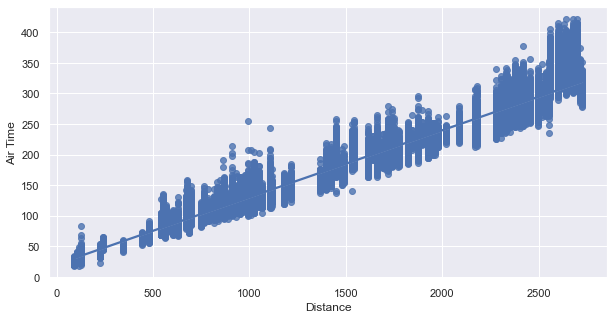

In [43]:
model=LinearRegression()
model.fit(x,y)
plt.figure(figsize=(10,5))
sns.regplot(x,y)
plt.xlabel('Distance')
plt.ylabel('Air Time')

Create categorical variables

In [44]:
df_flights = pd.get_dummies(df_flights, columns=['carrier'], prefix = ['carrier'])
df_flights.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,tailnum,flight,origin,...,carrier_AS,carrier_B6,carrier_DL,carrier_F9,carrier_HA,carrier_OO,carrier_UA,carrier_US,carrier_VX,carrier_WN
0,2014,1,1,1.0,96.0,235.0,70.0,N508AS,145,PDX,...,1,0,0,0,0,0,0,0,0,0
1,2014,1,1,4.0,-6.0,738.0,-23.0,N195UW,1830,SEA,...,0,0,0,0,0,0,0,1,0,0
2,2014,1,1,8.0,13.0,548.0,-4.0,N37422,1609,PDX,...,0,0,0,0,0,0,1,0,0,0
3,2014,1,1,28.0,-2.0,800.0,-23.0,N547UW,466,PDX,...,0,0,0,0,0,0,0,1,0,0
4,2014,1,1,34.0,44.0,325.0,43.0,N762AS,121,SEA,...,1,0,0,0,0,0,0,0,0,0


set x and y

In [59]:
x = df_flights[['distance','carrier_AA', 'carrier_AS', 'carrier_B6',
       'carrier_DL', 'carrier_F9', 'carrier_HA', 'carrier_OO', 'carrier_UA',
       'carrier_US', 'carrier_VX', 'carrier_WN']].values.reshape(-1,12)
y = df_flights['air_time'].values.reshape(-1,1)


Categorical regression

In [61]:
model=LinearRegression()
model.fit(x,y)
# print the intercept
print("model intercept: ",model.intercept_)


model intercept:  [19.85722577]


### Get regression parameters

In [63]:
import statsmodels.api as sm
# 'distance','carrier_AA', 'carrier_AS', 'carrier_B6',
#       'carrier_DL', 'carrier_F9', 'carrier_HA', 'carrier_OO', 'carrier_UA',
#      'carrier_US', 'carrier_VX', 'carrier_WN'
ls=sm.OLS(y,x).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 5.603e+05
Date:                Wed, 02 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:55:13   Log-Likelihood:            -6.2161e+05
No. Observations:              160748   AIC:                         1.243e+06
Df Residuals:                  160736   BIC:                         1.243e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1106   5.15e-05   2145.107      0.0